In [1]:
#%tensorflow_version 1.x
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Lendo base de dados

In [0]:
db = fetch_lfw_people()

In [0]:
faces = db['data']

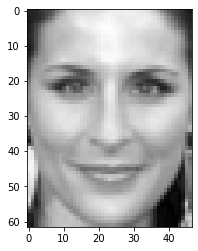

In [4]:
plt.imshow(faces[2000].reshape(62, 47), cmap='gray')

In [0]:
faces[0].shape

(2914,)

In [0]:
len(faces)

13233

In [0]:
type(faces)

numpy.ndarray

Tem um problema. As imagens sao em 62x47, que são dimensões bem ruins pq não dá pra comprimir em tamanhos muito distintos. São números primos/quase primos.

Solução por agora: tirar a primeira e ultima linha, e primeira e ultima coluna, transformando a imagem em 60x44, que é um número bem melhor pra comprimir para vários tamanhos diferentes.

In [0]:
faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

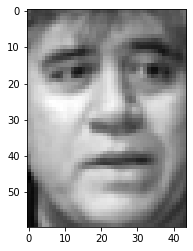

In [13]:
plt.imshow(faces_matrix[12000], cmap='gray')

In [0]:
# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Pensar se essa normalização faz sentido

# Pequena análise exploratória desses dados

Para a base toda concatenada:

In [0]:
gray2 = faces_matrix
print(f"Tamanho: {gray2.shape[0]}x{gray2.shape[1]}")
print(f"Média dos valores dos pixels: {np.mean(gray2)}")
print(f"Mediana dos valores dos pixels: {np.median(gray2)}")
print(f"Desvio padrão dos valores dos pixels: {np.std(gray2)}")
print(f"Outras estatísticas: \n{scipy.stats.describe(gray2.flatten())}")

Tamanho: 13233x60
Média dos valores dos pixels: 0.5121046723830129
Mediana dos valores dos pixels: 0.5267973656747855
Desvio padrão dos valores dos pixels: 0.1801153789396061
Outras estatísticas: 
DescribeResult(nobs=34935120, minmax=(0.0, 1.0), mean=0.5121046723830129, variance=0.03244155065918075, skewness=-0.30411404211836657, kurtosis=-0.29077007000635824)


Para cada imagem:

In [0]:
scipy.stats.describe(faces_matrix[3].flatten())

DescribeResult(nobs=2640, minmax=(0.030065358853807636, 0.8222222421683517), mean=0.3871692414292252, variance=0.042213388253118767, skewness=-0.0034709630893672077, kurtosis=-1.1031350935632616)

In [0]:
scipy.stats.describe(faces_matrix[0].flatten())[2] # mean
# scipy.stats.describe(faces_matrix[0].flatten())[3] # variance
# scipy.stats.describe(faces_matrix[0].flatten())[4] # skewness
# scipy.stats.describe(faces_matrix[0].flatten())[5] # kurtosis

0.4944177066982323

In [0]:
medias = np.zeros(len(faces_matrix))
variancias = np.zeros(len(faces_matrix))
assimetrias = np.zeros(len(faces_matrix))
curtoses = np.zeros(len(faces_matrix))
estatisticas = np.zeros(6)

for i in range(len(faces_matrix)):
  estatisticas = scipy.stats.describe(faces_matrix[i].flatten())
  medias[i] = estatisticas[2]
  variancias[i] = estatisticas[3]
  assimetrias[i] = estatisticas[4]
  curtoses[i] = estatisticas[5]


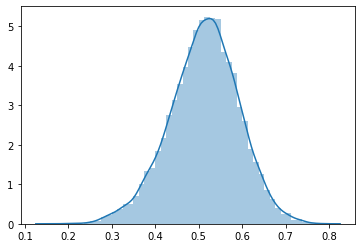

In [0]:
sns.distplot(medias)

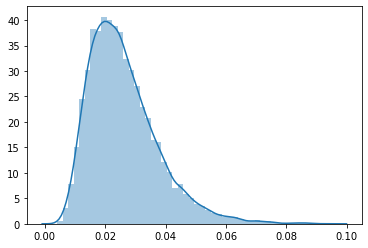

In [0]:
sns.distplot(variancias)

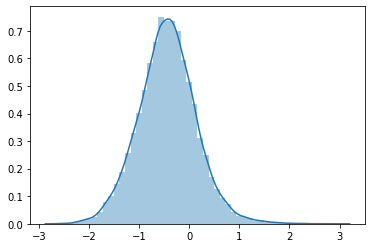

In [0]:
sns.distplot(assimetrias)

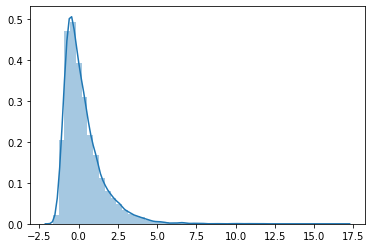

In [0]:
sns.distplot(curtoses)

Queria fazer essas imagens todas de uma vez só

TypeError: ignored

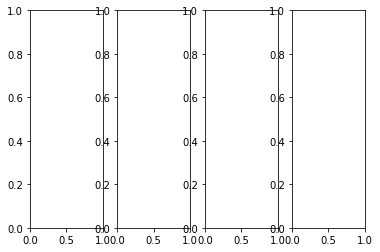

In [0]:
fig, axs = plt.subplots(ncols=4)
sns.distplot(medias)
sns.distplot(variancias)
sns.distplot(assimetrias)
sns.distplot(curtoses)

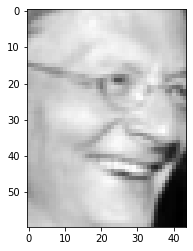

In [0]:
idx = np.where(curtoses > np.quantile(curtoses, 0.99)) # pega imagens que tem curtose no último percentil
plt.imshow(faces_matrix[idx][11], cmap = 'gray') # parece que são imagens muito escuras ou muito claras. ou com pouca variancia na luminosidade?
# é inversamente proporcional à variancia

In [0]:
idx = np.where(medias > np.quantile(medias, 0.99)) # pega imagens que tem medias no último percentil

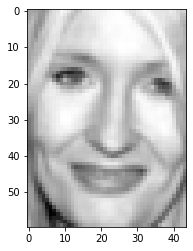

In [0]:
plt.imshow(faces_matrix[idx][129], cmap = 'gray') # imagens mais claras

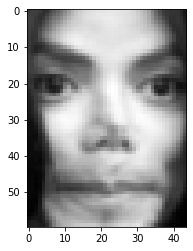

In [0]:
idx = np.where(variancias > np.quantile(variancias, 0.99)) # pega imagens que tem variancias no último percentil
plt.imshow(faces_matrix[idx][10], cmap = 'gray') # imagens com contraste muito alto

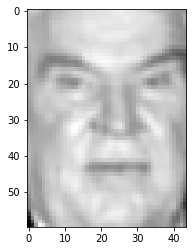

In [0]:
idx = np.where(variancias < np.quantile(variancias, 0.01)) # pega imagens que tem variancias no último percentil
plt.imshow(faces_matrix[idx][10], cmap = 'gray') # imagens com contraste muito alto

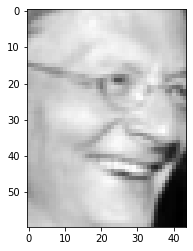

In [0]:
idx = np.where(assimetrias < np.quantile(assimetrias, 0.01)) # pega imagens que tem assimetrias no último percentil
plt.imshow(faces_matrix[idx][7], cmap = 'gray') # imagens muito escuras
# inversamente proporcional à variancia tbm

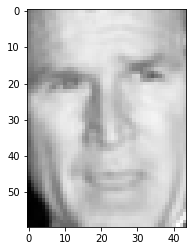

In [0]:
# idx = np.where(assimetrias < np.quantile(assimetrias, 0.01)) # pega imagens que tem assimetrias no primeiro percentil
plt.imshow(faces_matrix[idx][2], cmap = 'gray') # imagens muito claras

# Dúvida

In [0]:
1/scipy.stats.variation(faces_matrix[3].flatten()) # -> Isso é o SNR?

1.8847684782785092

In [0]:
# Vendo a distribuição
snrs = np.zeros(len(faces_matrix))

for i in range(len(faces_matrix)):
  snrs[i] = 1/scipy.stats.variation(faces_matrix[i].flatten())

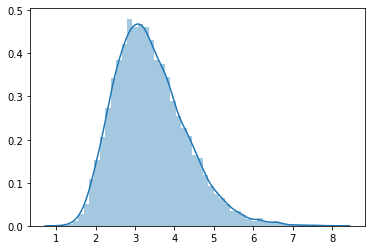

In [0]:
sns.distplot(snrs)

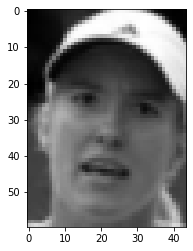

In [0]:
idx = np.where(snrs < np.quantile(snrs, 0.01)) # pega imagens que tem SNR no 1o percentil
plt.imshow(faces_matrix[idx][8], cmap = 'gray') # imagens muito contrastantes?
# inversamente proporcional à variancia tbm

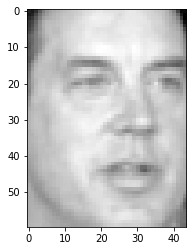

In [0]:
idx = np.where(snrs > np.quantile(snrs, 0.99)) # pega imagens que tem SNR no último percentil
plt.imshow(faces_matrix[idx][3], cmap = 'gray') # imagens pouco contrastantes?
# inversamente proporcional à variancia tbm

# Adicionando ruído às imagens



## Atenção: vou sobrescrever `faces`. Não sei se isso é uma boa prática.

In [0]:
del faces
faces = faces_matrix

In [0]:
# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    # vou parar de clipar.
    return newgray

In [0]:
newfaces = add_noise(0.05, faces)

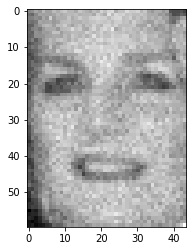

In [13]:
plt.imshow(newfaces[2010].reshape(60, 44), cmap='gray')

No Keras tem esses tipos de layers:

* core layers

* convolutional layers

* pooling layers

* locally connected layers

* recurrent layers

* embedding layers

* merge layers

* advanced activations layers

* normalization layers

* noise layers

## Definindo DAE pequeno, só com core layers

In [0]:
# Definindo DAE
k = 30
shape = (60, 44)

In [0]:
inputs  = Input(shape = (np.prod(shape), )) # flattened image
enc_fc  = Dense(k, activation = 'relu') # encode to k data points
encoded = enc_fc(inputs)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
dec_fc  = Dense(np.prod(shape), activation = 'sigmoid') # to original size
decoded = dec_fc(encoded)

In [0]:
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [0]:
autoencoder.fit(newfaces, faces, epochs=50, batch_size=128)

In [0]:
pred = autoencoder.predict(faces)

In [0]:
plt.imshow(pred[2004].reshape(62, 47), cmap='gray')

# SOCORROOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

## Fazendo DAE um pouco maior (ainda só core layers)

Activations possíveis: https://keras.io/activations/

In [0]:
k = 10
shape = (60, 44)

In [0]:
def make_core_dae():
    # encode
    inputs = Input(shape = (np.prod(shape), ))
    x  = Dense(50, activation = 'tanh')(inputs)
    x  = Dropout(0.5)(x)
    x  = Dense(k, activation = 'relu')(x)
    
    # decode
    x  = Dense(50, activation = 'tanh')(x)
    
    decoded  = Dense(np.prod(shape), activation = 'sigmoid')(x)
    
    # build autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [0]:
autoencoder2 = make_core_dae()

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
autoencoder2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2914)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                145750    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 2914)              148614    
Total params: 295,424
Trainable params: 295,424
Non-trainable params: 0
_____________________________________________________

In [0]:
autoencoder2.fit(newfaces, faces, epochs=50, batch_size=128)

Epoch 1/30
13233/13233 [==============================] - 2s 166us/step - loss: 0.6649
Epoch 2/30
13233/13233 [==============================] - 2s 161us/step - loss: 0.6647
Epoch 3/30
13233/13233 [==============================] - 2s 163us/step - loss: 0.6642
Epoch 4/30
13233/13233 [==============================] - 2s 165us/step - loss: 0.6638
Epoch 5/30
13233/13233 [==============================] - 2s 165us/step - loss: 0.6638
Epoch 6/30
13233/13233 [==============================] - 2s 166us/step - loss: 0.6633
Epoch 7/30
13233/13233 [==============================] - 2s 162us/step - loss: 0.6628
Epoch 8/30
13233/13233 [==============================] - 2s 164us/step - loss: 0.6627
Epoch 9/30
13233/13233 [==============================] - 2s 173us/step - loss: 0.6621
Epoch 10/30
13233/13233 [==============================] - 2s 158us/step - loss: 0.6624
Epoch 11/30
13233/13233 [==============================] - 2s 169us/step - loss: 0.6618
Epoch 12/30
13233/13233 [================

In [0]:
pred2 = autoencoder2.predict(faces)

In [0]:
plt.imshow(pred2[0].reshape(62, 47), cmap='gray')

NameError: name 'pred2' is not defined

## Convolutional autoencoder com ReLU com perda cross entropy

In [0]:
def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(60, 44, 1)) # input_4 (None, 60, 44, 1) 
    x = Conv2D( 16, 3, activation='relu', padding='same')(inputs) # conv2d_9 (None, 62, 47, 16)
    x = MaxPooling2D(padding='same')(x) # max_pooling2d_4 (None, 31, 24, 16)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) # conv2d_10 (None, 31, 24, 8)
    x = MaxPooling2D(padding='same')(x) # max_pooling2d_5 (None, 16, 12, 8)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) # conv2d_11 (None, 16, 12, 8)
    encoded = MaxPooling2D(padding='same')(x) # max_pooling2d_6 (None, 8, 6, 8)
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded) # conv2d_12 (None, 62, 47, 16)
    x = UpSampling2D()(x) # up_sampling2d_4 (None, 16, 12, 8)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) # conv2d_13 (None, 16, 12, 8)
    x = UpSampling2D()(x) # up_sampling2d_5 (None, 32, 24, 8)
    x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'! # conv2d_14 (None, 30, 22, 16)
    x = UpSampling2D()(x) # up_sampling2d_6 (None, 60, 44, 16)
    #decoded = Dense(1, activation = 'sigmoid')(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x) # conv2d_15 (None, 60, 44, 1)  
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [0]:
deep_autoencoder = make_convolutional_autoencoder()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
deep_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 22, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 11, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 11, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 6, 8)           0   

In [0]:
# tem que fazer reshape pq os inputs e outputs, qdo passam pela conv2D, passam a ser tensores com 4 dimensões.

newfaces = newfaces.reshape(-1, 60, 44, 1)
faces = faces.reshape(-1, 60, 44, 1)

In [0]:
deep_autoencoder.fit(newfaces, faces, epochs=1, batch_size=10) # botando 1 epoch e batch size = 10 só para ver se dá certo. antes tava 50 epochs e 128 de batch size, corrigir

Epoch 1/1
13233/13233 [==============================] - 72s 5ms/step - loss: 0.6349


In [0]:
pred_deep = deep_autoencoder.predict(faces)

## Input, output e imagem original

In [0]:
def plota_pra_mim_pfv(pred, numero):
    figures, axes = plt.subplots(1,3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

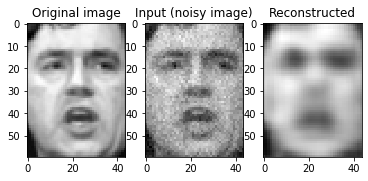

In [0]:
plota_pra_mim_pfv(pred_deep, 2004)

## DAE convolucional com relu e cross entropy. (pequeno) - comportamento melhor - **vou fixar essa arquitetura**

In [0]:
sklearn.model_selection.train_test_split

In [0]:
def make_small_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(60, 44, 1)) 
    x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
    x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
    x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
    encoded = MaxPooling2D(padding = 'same')(x)
    
    # decoding
    x = UpSampling2D(size = (2, 2))(x)
    decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)  
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return autoencoder

In [15]:
small_conv_autoencoder = make_small_convolutional_autoencoder()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
small_conv_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 22, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
_________________________________________________________

In [0]:
small_conv_autoencoder.fit(newfaces, faces, epochs=10, batch_size=128)

Epoch 1/1
13233/13233 [==============================] - 38s 3ms/step - loss: 0.6502


In [0]:
pred_small = small_conv_autoencoder.predict(faces)

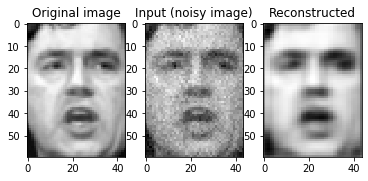

In [0]:
plota_pra_mim_pfv(pred_small, 2004)

## Variando tamanho do código

Fatores que a primeira dimensao pode variar: 1, 2, 4, 12, 20

Fatores que a segunda dimensao pode variar: 1, 2, 4


In [0]:
def make_small_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(60, 44, 1)) 
    x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
    x = MaxPooling2D(pool_size = (20,4), padding = 'same')(x)
    x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
    encoded = MaxPooling2D(padding = 'same')(x)
    
    # decoding
    x = UpSampling2D(size = (20, 4))(x)
    decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return autoencoder
small_conv_autoencoder = make_small_convolutional_autoencoder()
small_conv_autoencoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 3, 11, 16)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 3, 11, 8)          1160      
_________________________________________________________________
up_sampling2d_24 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

## (1,2)

In [0]:
fatores1 = (1, 2, 4, 12, 20)
fatores2 = (1, 2, 4)
autoencoders = [None] * len(fatores1) * len(fatores2)
cont = 0

for i in fatores1:
  for j in fatores2:
    def make_autoencoder():
      # encoding
      inputs = Input(shape=(60, 44, 1)) 
      x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
      x = MaxPooling2D(pool_size = (i, j), padding = 'same')(x)
      x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
      encoded = MaxPooling2D(padding = 'same')(x)
      
      # decoding
      x = UpSampling2D(size = (i, j))(x)
      decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
      
      # autoencoder
      autoencoder = Model(inputs, decoded)
      autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
      return autoencoder
    autoencoders[cont] = make_autoencoder()
    cont += 1

In [0]:
autoencoders[11].summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 5, 11, 16)         0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 5, 11, 8)          1160      
_________________________________________________________________
up_sampling2d_39 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

Fittando

In [0]:
cont = 0
for i in fatores1:
  for j in fatores2:
    autoencoders[cont].fit(newfaces, faces, epochs=50, batch_size=20)
    cont += 1

Epoch 1/50
13233/13233 [==============================] - 59s 4ms/step - loss: 0.6523
Epoch 2/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6266
Epoch 3/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6260
Epoch 4/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6258
Epoch 5/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6256
Epoch 6/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6255
Epoch 7/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6254
Epoch 8/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6253
Epoch 9/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6253
Epoch 10/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6252
Epoch 11/50
13233/13233 [==============================] - 58s 4ms/step - loss: 0.6252
Epoch 12/50
13233/13233 [===========================

Predizendo

In [0]:
predicoes = [None] * len(fatores1) * len(fatores2)
cont = 0

for i in fatores1:
  for j in fatores2:
    predicoes[cont] = autoencoders[cont].predict(faces)